In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image


# Class Dataset

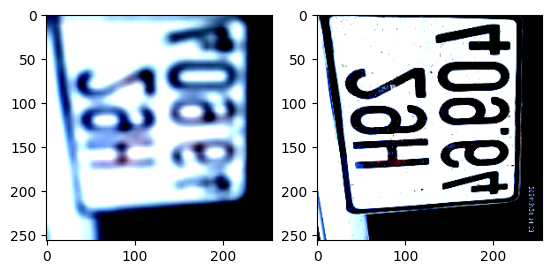

In [ ]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, resize_tup):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        self.resize_tup = resize_tup
        self.transforms = transforms.Compose([
            transforms.Resize(self.resize_tup),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"/content/LR_data"
HR_path = r"/content/HR_data"
Dataset = LicensePlateDataset(LR_path, HR_path, (256,256))

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

# Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self,in_channel, out_channel):
        super().__init__()
        self.component = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self,x):
        return self.component(x)

skip_connection = []
class Encoder(nn.Module):
    def __init__(self, in_channel, feature_list):
        super().__init__()
        self.feature_list = feature_list
        self.downs = nn.ModuleList()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottom = DoubleConv(feature_list[-1], feature_list[-1]*2)

        for feature in self.feature_list:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature

    def forward(self,x):
        for down in self.downs:
            x = down(x)
            # print(x.shape)
            skip_connection.append(x)
            x = self.maxpool2d(x)
        x = self.bottom(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channel, reversed_feature_list):
        """
        Reversed_feature_list[0] == laten_space_channel//2
        """
        super().__init__()
        self.ups=nn.ModuleList()
        self.lastConv2d = nn.Conv2d(reversed_feature_list[-1], out_channel,kernel_size=1)

        for feature in reversed_feature_list:
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2, padding=0))
            self.ups.append(DoubleConv(feature*2, feature))

    def forward(self, x):
        for i in range(0,len(self.ups),2):
            x = self.ups[i](x)

            if x.shape != skip_connection[len(skip_connection)-1-i//2].shape:
                x = TF.resize(x, size=skip_connection[len(skip_connection)-1-i//2].shape[2:])
            x = torch.cat([skip_connection[len(skip_connection)-1-i//2], x],axis=1)

            x = self.ups[i+1](x)
        return self.lastConv2d(x)


# Add noise and avarage pooling

In [ ]:
def to_soil(embedding_vector, noise_factor, kernel_avg):

    noise = torch.randn_like(embedding_vector) * noise_factor
    embedding_vector = embedding_vector + noise
    embedding_vector = F.avg_pool2d(embedding_vector, kernel_size=kernel_avg, stride=1, padding=(kernel_avg-1)//2)
    return embedding_vector

# Test output shape

In [ ]:
enc1 = Encoder(3,[64])
enc2 = Encoder(128,[128])
enc3 = Encoder(256,[256])

dec3 = Decoder(256,[256])
x = torch.rand(1,3,64,64)

out_enc1 = enc1(x)
print("Kích thước sau khi đi qua encoder 1: ", out_enc1.shape)
out_enc2 = enc2(out_enc1)
print("Kích thước sau khi đi qua encoder 2: ",out_enc2.shape)
out_enc3 = enc3(out_enc2)
print("Kích thước sau khi đi qua encoder 3: ",out_enc3.shape)

out_dec3 = dec3(out_enc3)
print("Kích thước sau khi đi qua decoder3: ",out_dec3.shape)

Kích thước sau khi đi qua encoder 1:  torch.Size([1, 128, 32, 32])
Kích thước sau khi đi qua encoder 2:  torch.Size([1, 256, 16, 16])
Kích thước sau khi đi qua encoder 3:  torch.Size([1, 512, 8, 8])
Kích thước sau khi đi qua decoder3:  torch.Size([1, 256, 16, 16])


In [ ]:
epochs = 10
device = 'cuda'
loss_fn = nn.MSELoss()

image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)

enc1 = Encoder(3,[64]).to(device)
enc2 = Encoder(128,[128]).to(device)
enc3 = Encoder(256,[256]).to(device)

dec3 = Decoder(256,[256]).to(device)
# Load encoder 1, encoder 2
enc1.load_state_dict(torch.load("enc1.pth"))
enc2.load_state_dict(torch.load("enc2.pth"))


optimizer1 = Adam(enc1.parameters(),lr=0.0001)
optimizer2 = Adam(enc2.parameters(),lr=0.0001)
optimizer3 = Adam(enc3.parameters(),lr=0.0001)
optimizer4 = Adam(dec3.parameters(),lr=0.0001)

skip_connection = []
for epoch in range(epochs):
  enc1.train(), enc2.train(),enc3.train(), dec3.train()
  sum_loss = 0
  n=len(dataloader)
  for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        optimizer4.zero_grad()
        # First embedding vector(output of encoder1)
        first_embedding_vector = enc1(LR_image)
        # Second embedding vector(output of encoder1)
        second_embedding_vector = enc2(first_embedding_vector)
        # Make noise embedding vector with 0.1 noise factor and 3x3 avarage pooling
        soil_embedding_vector = to_soil(second_embedding_vector, 0.1, 3)
        # Third embedding vector
        third_embedding_vector = enc3(soil_embedding_vector)
        # Decode third embedding vector
        clean_embedding_vector = dec3(third_embedding_vector)

        loss = loss_fn(clean_embedding_vector, second_embedding_vector)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        optimizer4.step()

        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

<ipython-input-11-2f8844328628>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc1.load_state_dict(torch.load("enc1.pth"))
<ipython-input-11-2f8844328628>:15: FutureWarn

Epoch 1 : Loss 0.1599104255437851
Epoch 2 : Loss 0.017653726041316986
Epoch 3 : Loss 0.005586785729974508
Epoch 4 : Loss 0.0028621170204132795
Epoch 5 : Loss 0.001993016805499792
Epoch 6 : Loss 0.0017738908063620329
Epoch 7 : Loss 0.0013591316528618336
Epoch 8 : Loss 0.0011138018453493714
Epoch 9 : Loss 0.001020666677504778
Epoch 10 : Loss 0.0008818014175631106


In [ ]:
torch.save(enc1.state_dict(), "enc1.pth")
torch.save(enc2.state_dict(), "enc2.pth")
torch.save(enc3.state_dict(), "enc3.pth")
torch.save(dec3.state_dict(), "dec_embedding.pth")

# Traing decoder 3

In [ ]:
epochs = 10
device = 'cuda'
loss_fn = nn.MSELoss()

image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)

enc1 = Encoder(3,[64]).to(device)
enc2 = Encoder(128,[128]).to(device)
enc3 = Encoder(256,[256]).to(device)
dec3 = Decoder(3,[256,128,64]).to(device)

enc1.load_state_dict(torch.load("enc1.pth"))
enc2.load_state_dict(torch.load("enc2.pth"))
enc3.load_state_dict(torch.load("enc3.pth"))

model = nn.Sequential(enc1,enc2,enc3,dec3)
optimizer = Adam(dec3.parameters(),lr=0.0001)
skip_connection = []
for epoch in range(epochs):
  dec3.train()
  sum_loss = 0
  n=len(dataloader)
  for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        optimizer.zero_grad()

        HR_output = model(LR_image)

        loss = loss_fn(HR_output, HR_image)
        loss.backward()
        optimizer.step()

        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

<ipython-input-13-f0a761406c1d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc1.load_state_dict(torch.load("enc1.pth"))
<ipython-input-13-f0a761406c1d>:14: FutureWarn

Epoch 1 : Loss 0.4042961597442627
Epoch 2 : Loss 0.17018777132034302
Epoch 3 : Loss 0.12150527536869049
Epoch 4 : Loss 0.09966613352298737
Epoch 5 : Loss 0.09390020370483398
Epoch 6 : Loss 0.08966504037380219
Epoch 7 : Loss 0.084213025867939
Epoch 8 : Loss 0.08096444606781006
Epoch 9 : Loss 0.07880652695894241
Epoch 10 : Loss 0.07495018094778061


In [ ]:
torch.save(dec3.state_dict(), "dec3.pth")

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

9179971

# Evaluation

In [ ]:
import numpy as np
import cv2


def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def calculate_ssim(img1, img2):

    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tách các kênh màu (RGB)
    ssim_values = []
    for i in range(3):  # Duyệt qua 3 kênh màu
        ssim_value = ssim(img1[:, :, i], img2[:, :, i], data_range=img2[:, :, i].max() - img2[:, :, i].min())
        ssim_values.append(ssim_value)

    # Tính SSIM trung bình trên 3 kênh
    return np.mean(ssim_values)

import cv2
import numpy as np

def calculate_nmse(img1, img2):

    # Kiểm tra kích thước ảnh
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tính NMSE
    numerator = np.sum((img1 - img2) ** 2)
    denominator = np.sum(img2 ** 2)
    nmse_value = numerator / denominator if denominator != 0 else float('inf')
    return nmse_value

In [ ]:
device = 'cuda'
enc1 = Encoder(3,[64]).to(device)
enc2 = Encoder(128,[128]).to(device)
enc3 = Encoder(256,[256]).to(device)
dec3 = Decoder(3,[256,128,64]).to(device)

enc1.load_state_dict(torch.load("enc1.pth"))
enc2.load_state_dict(torch.load("enc2.pth"))
enc3.load_state_dict(torch.load("enc3.pth"))
dec3.load_state_dict(torch.load("dec3.pth"))

<ipython-input-6-997b3c519d23>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc1.load_state_dict(torch.load("enc1.pth"))
<ipython-input-6-997b3c519d23>:8: FutureWarning:

<All keys matched successfully>

In [ ]:
import numpy as np
device = 'cuda'
psnr_score = []
ssim_score = []
nmse_score = []
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
model = nn.Sequential(enc1,enc2,enc3,dec3)
model.to(device)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()

        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr_score.append(calculate_psnr(HR_image,HR_output))
        ssim_score.append(calculate_ssim(HR_image,HR_output))
        nmse_score.append(calculate_nmse(HR_image,HR_output))

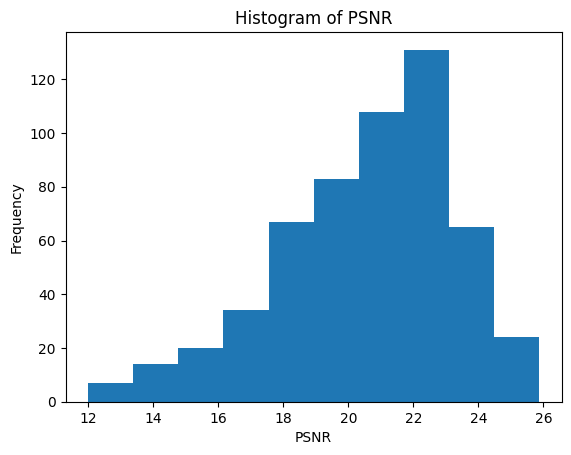

In [ ]:
plt.hist(psnr_score)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

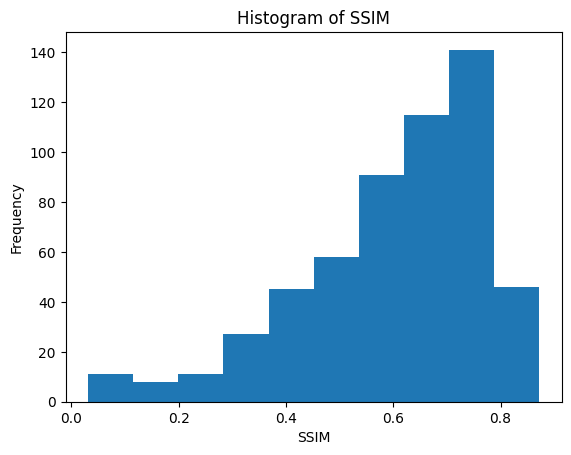

In [ ]:
plt.hist(ssim_score)
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("Histogram of SSIM")
plt.show()

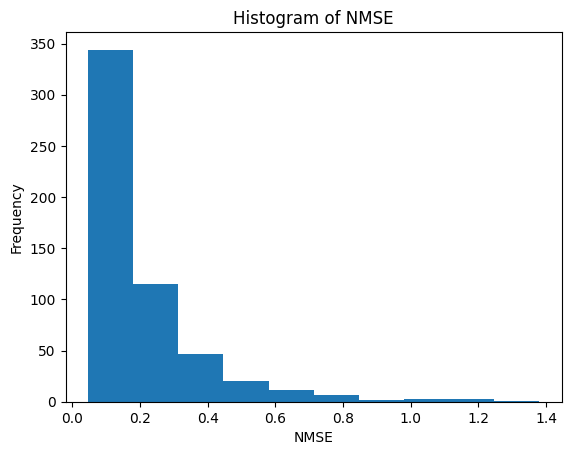

In [ ]:
plt.hist(nmse_score)
plt.xlabel("NMSE")
plt.ylabel("Frequency")
plt.title("Histogram of NMSE")
plt.show()

In [ ]:
import pandas as pd
three_stack_dict = {"METHOD":"3SAE","PSNR":psnr_score, "SSIM":ssim_score,"NMSE":nmse_score}
three_stack_df = pd.DataFrame(three_stack_dict)
three_stack_df.shape

(553, 4)

In [ ]:
three_stack_df.to_csv("3SAE.csv")